In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import random as r
import matplotlib.pyplot as plt
from collections import Counter
import tqdm
from sklearn.base import clone
import ast

C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# -----------------------------
# 1. Load your datasets
# -----------------------------
print("Loading datasets...")
reviews_df = pd.read_csv("./archive/dataset.csv")  # columns: app_id, app_name, review_text


Loading datasets...


In [19]:
tags_df = pd.read_csv("comp/tagGamesDF.csv")
tagCountsDF = pd.read_csv("comp/tagCountsDF.csv")
tags_df.head(10)

,APPID,tags
0,10,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C..."
1,1002,"['2D Fighter', 'Martial Arts', 'Intentionally ..."
2,100400,"['Animation & Modeling', 'Software']"
3,10090,"['Zombies', 'World War II', 'FPS', 'Multiplaye..."
4,100980,"['Animation & Modeling', 'Utilities', 'Design ..."
5,10100,"['Adventure', 'Point & Click', 'Classic', 'Fan..."
6,10110,"['Adventure', 'Point & Click', 'Classic', 'Com..."
7,10120,"['Action', 'Casual', 'Space', 'On-Rails Shoote..."
8,10130,"['Action', 'FPS', 'Time Manipulation', 'Sci-fi..."
9,10140,"['Sports', 'Mini Golf', 'Golf', 'Local Multipl..."


In [7]:
def filter_rare_tags_by_game(tags_df, tagCountsDF, min_count=1, max_count=7000):
    # Keep tags within the occurrence thresholds
    allowed_tags = set(tagCountsDF.loc[
        (tagCountsDF['occurrences'] >= min_count) & (tagCountsDF['occurrences'] <= max_count),
        'tag'
    ])
    
    # Filter tags per game
    tags_df['tags'] = tags_df['tags'].apply(lambda lst: [tag for tag in lst if tag in allowed_tags])
    
    # Drop games with no tags left
    tags_df = tags_df[tags_df['tags'].str.len() > 0].reset_index(drop=True)
    
    return tags_df


100 Counter({'Indie': 6304, 'Action': 5048, 'Singleplayer': 4482, 'Adventure': 4335, 'Casual': 3422, 'Strategy': 2523, 'Multiplayer': 2068, 'Simulation': 2068, 'RPG': 1991, '2D': 1990, 'Atmospheric': 1737, 'Puzzle': 1722, 'Great Soundtrack': 1630, 'Story Rich': 1327, 'Shooter': 1198, 'Sci-fi': 1196, 'First-Person': 1134, 'Platformer': 1117, 'Funny': 1100, 'Fantasy': 1089, 'Difficult': 1086, 'Open World': 1061, 'Co-op': 1060, 'Pixel Graphics': 1049, 'Horror': 1044, 'Female Protagonist': 1041, 'Arcade': 953, 'Retro': 950, 'Free to Play': 887, 'Point & Click': 824, 'Anime': 813, 'Classic': 802, 'FPS': 776, 'Early Access': 774, 'Exploration': 757, 'Comedy': 755, 'Survival': 723, 'Family Friendly': 722, 'Sandbox': 712, 'Third Person': 690, 'Cute': 646, 'Turn-Based': 627, 'Space': 626, 'Gore': 579, 'Controller': 538, 'Tactical': 495, 'Local Co-Op': 484, 'Local Multiplayer': 483, 'Colorful': 480, 'Psychological Horror': 466, 'Sports': 453, 'Visual Novel': 440, 'Online Co-Op': 429, 'Racing': 4

In [9]:
# -----------------------------
# 2. Aggregate reviews per game (only games with tags available)
# -----------------------------

print("Aggregating reviews per game...")

reviews_df['app_id'] = reviews_df['app_id'].astype(int)
tags_df['APPID'] = tags_df['APPID'].astype(int)

# Filter reviews to only include games present in tags_df
reviews_with_tags = reviews_df[reviews_df['app_id'].isin(tags_df['APPID'])]
print(reviews_with_tags.head(5))

# Convert review_text to string
reviews_with_tags['review_text'] = reviews_with_tags['review_text'].astype(str)

# Filter out reviews shorter than 3 words
reviews_with_tags = reviews_with_tags.loc[reviews_with_tags['review_text'].str.split().str.len() >= 3]

print("Filtered reviews shape:", reviews_with_tags.shape)

# Aggregate reviews per game and keep app_name
game_reviews = (
    reviews_with_tags.groupby('app_id')
    .agg({
        'review_text': lambda texts: " ".join(texts),
        'app_name': 'first'  # keep the first app_name per app_id
    })
    .reset_index()
)
print("Aggregated reviews shape:", game_reviews.shape)

# Merge with filtered tags
game_reviews = game_reviews.merge(tags_df, left_on='app_id', right_on='APPID')
print("Merged game_reviews shape:", game_reviews.shape)

print("Sample data:")
print(game_reviews.head())


Aggregating reviews per game...
   app_id        app_name                                        review_text  \
0      10  Counter-Strike                                    Ruined my life.   
1      10  Counter-Strike  This will be more of a ''my experience with th...   
2      10  Counter-Strike                      This game saved my virginity.   
3      10  Counter-Strike  • Do you like original games? • Do you like ga...   
4      10  Counter-Strike           Easy to learn, hard to master.             

   review_score  review_votes  
0             1             0  
1             1             1  
2             1             0  
3             1             0  
4             1             1  


C:\Users\joris\AppData\Local\Temp\ipykernel_20360\3972742872.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_with_tags['review_text'] = reviews_with_tags['review_text'].astype(str)


Filtered reviews shape: (6253052, 5)
Aggregated reviews shape: (9833, 3)
Merged game_reviews shape: (9833, 5)
Sample data:
   app_id                                        review_text  \
0      10  Ruined my life. This will be more of a ''my ex...   
1      20  When I got this for Christmas in 1999 along wi...   
2      30  Even though its old, its better than Call of D...   
3      40  Buy this game and join the community of one Th...   
4      50  This is the first game created by Gearbox - th...   

                    app_name  APPID  \
0             Counter-Strike     10   
1      Team Fortress Classic     20   
2              Day of Defeat     30   
3         Deathmatch Classic     40   
4  Half-Life: Opposing Force     50   

                                                tags  
0  [Action, FPS, Multiplayer, Shooter, Classic, T...  
1  [Action, FPS, Multiplayer, Classic, Shooter, T...  
2  [FPS, Multiplayer, Shooter, Action, War, Team-...  
3  [Action, FPS, Classic, Multiplayer

In [10]:
lengths = ([len(i) for i in game_reviews['review_text']])
reviews = []

reviews_counts = reviews_df.groupby('app_id').size()
tags_lookup = game_reviews.set_index('app_id')['tags']

for app_id, count in tqdm.tqdm(reviews_counts.items()):
    num_tags = len(tags_lookup.get(app_id, []))
    reviews.append(np.array([count, num_tags]))

reviews = np.array(reviews)


# reviews = Counter(reviews)
print(len(reviews)) # 4521
print(max(reviews_counts)) # 88973
print(min(reviews_counts)) # 1

print(reviews)

9972it [00:00, 337823.58it/s]

9972
88973
1
[[12353    13]
 [ 1542    12]
 [ 1030    16]
 ...
 [   20     6]
 [    3     1]
 [    5     4]]


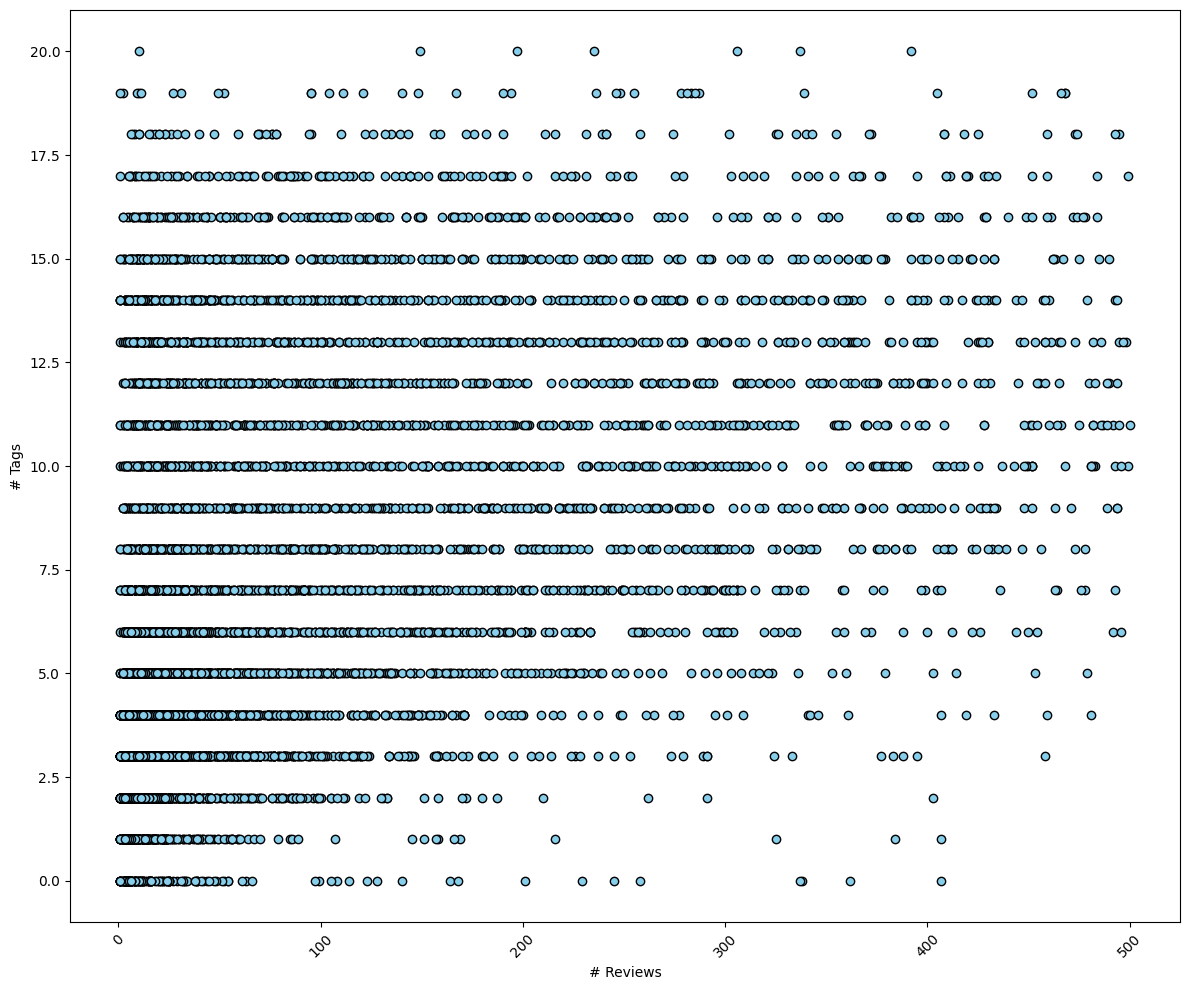

In [ ]:
def filter_by_review_threshold(reviews, max_reviews):
    return [r for r in reviews if r[0] <= max_reviews]

plt.figure(figsize=(12,10))

reviews = filter_by_review_threshold(reviews, 500)
x = [r[0] for r in reviews]  # number of reviews
y = [r[1] for r in reviews]  # number of tags

plt.scatter(x, y , color="skyblue", edgecolor="black")

plt.title("")
plt.xlabel("# Reviews")
plt.ylabel("# Tags")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:

reviews = reviews[reviews[:, 1].argsort()]
reviews

array([[  1,   0],
       [  3,   0],
       [  1,   0],
       ...,
       [124,  20],
       [315,  20],
       [180,  20]])

In [ ]:
min_reviews_for_tag = [[i, None, None, None] for i in range(21)]

min_reviews = 0

# assuming your array is named arr
for tag in range(21):
    # filter rows where column 1 == tag
    values = reviews[reviews[:, 1] == tag][:, 0]
    if values.size > 0:
        min_reviews_for_tag[tag][1] = values.min()
        min_reviews_for_tag[tag][2] = values.max()
        min_reviews_for_tag[tag][3] = round(values.mean(), 3)



(np.array(min_reviews_for_tag))



array([[0.000000e+00, 1.000000e+00, 6.940000e+02, 5.370800e+01],
       [1.000000e+00, 1.000000e+00, 3.370000e+02, 2.464300e+01],
       [2.000000e+00, 1.000000e+00, 3.620000e+02, 2.110600e+01],
       [3.000000e+00, 1.000000e+00, 7.700000e+02, 3.046100e+01],
       [4.000000e+00, 1.000000e+00, 1.106000e+03, 3.692900e+01],
       [5.000000e+00, 1.000000e+00, 4.530000e+02, 4.886800e+01],
       [6.000000e+00, 1.000000e+00, 9.210000e+02, 6.477600e+01],
       [7.000000e+00, 1.000000e+00, 1.138000e+03, 7.988600e+01],
       [8.000000e+00, 2.000000e+00, 1.742000e+03, 1.112390e+02],
       [9.000000e+00, 1.000000e+00, 1.389000e+03, 1.439390e+02],
       [1.000000e+01, 1.000000e+00, 1.552000e+03, 1.662330e+02],
       [1.100000e+01, 1.000000e+00, 2.563000e+03, 1.872080e+02],
       [1.200000e+01, 1.000000e+00, 3.062000e+03, 2.255220e+02],
       [1.300000e+01, 2.000000e+00, 2.327000e+03, 2.541170e+02],
       [1.400000e+01, 3.000000e+00, 2.534000e+03, 2.450550e+02],
       [1.500000e+01, 2.0

In [134]:
# -----------------------------
# 3. Encode text to embeddings
# -----------------------------
def encode_and_save_embeddings(game_reviews, model_name="all-mpnet-base-v2", output_file="game_review_embeddings--all-mpnet-base-v2--top100.npy"):
    print("Encoding text to embeddings...")
    model = SentenceTransformer(model_name)
    data = model.encode(game_reviews['review_text'].tolist(), show_progress_bar=True)
    np.save(output_file, data)
    return data

reembed = False
if reembed:
    data = encode_and_save_embeddings(game_reviews)
else:
    data = np.load("game_review_embeddings(all-mpnet-base-v2).npy")


Encoding text to embeddings...


Batches: 100%|██████████| 308/308 [58:13<00:00, 11.34s/it] 


In [135]:
# -----------------------------
# 4. Encode tags to multilabel format
# -----------------------------
print("Encoding tags to multilabel format...")
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(game_reviews['tags'])

Encoding tags to multilabel format...


In [136]:
# -----------------------------
# 5. Train/Test split
# -----------------------------
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test, train_ids, test_ids, train_names, test_names = train_test_split(
    data, y, game_reviews['app_id'], game_reviews['app_name'], test_size=0.15, random_state=69
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Splitting data into train and test sets...
(8358, 768) (8358, 98) (1475, 768) (1475, 98)


In [137]:
from sklearn.model_selection import KFold

def kfoldprobs(X_train, y_train, X_test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Store test probabilities from each fold
    test_probs_folds = []

    for train_index, val_index in tqdm.tqdm(kf.split(X_train)):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        clf = OneVsRestClassifier(LogisticRegression(max_iter=10000))
        clf.fit(X_tr, y_tr)

        # Predict probabilities on your **held-out test set** (not validation fold)
        probs_test = clf.predict_proba(X_test)
        test_probs_folds.append(probs_test)

    # Average probabilities across folds
    probs_test_avg = np.mean(test_probs_folds, axis=0)
    return probs_test_avg


In [138]:
def median_class_weights_linear(X_train, y_train, X_test):
    n_labels = y_train.shape[1]
    label_counts = np.sum(y_train, axis=0)
    median_count = np.median(label_counts)
    
    # Compute per-label median-based weights
    median_class_weights = [{0: 1.0, 1: (median_count / count)*1.8} for count in label_counts]
    
    # Train one LogisticRegression per label
    y_pred = []
    base_clf = LogisticRegression(max_iter=10000, solver='liblinear')
    for i in range(n_labels):
        clf = clone(base_clf)
        clf.set_params(class_weight=median_class_weights[i])
        clf.fit(X_train, y_train[:, i])
        y_pred.append(clf.predict_proba(X_test)[:, 1])  # get probability for positive class
    
    # Stack predictions as (n_samples, n_labels)
    return np.column_stack(y_pred)


In [139]:
# -----------------------------
# 6. Train multilabel classifier
# -----------------------------
def simple_linear(X_train, y_train):
    print("Training multilabel classifier...")
    clf = OneVsRestClassifier(LogisticRegression(max_iter=10000))
    clf.fit(X_train, y_train)
    return clf.predict_proba(X_test)

In [140]:
# Pick top 5 tags per game
def get_top_n_tags(probs, top_n=20):
    top_n_pred_tags = []
    for prob_row in probs:
        top_indices = prob_row.argsort()[-top_n:][::-1]  # indices of top N probs
        top_tags = [mlb.classes_[i] for i in top_indices]
        top_n_pred_tags.append(top_tags)
    return top_n_pred_tags

def get_treshhold_tags(probs, threshold=0.25):
    dynamic_pred_tags = []

    for prob_row in probs:
        # Get indices where probability > threshold
        tag_indices = np.where(prob_row > threshold)[0]

        if len(tag_indices) == 0:
            # fallback: pick the top 1 tag
            tag_indices = [np.argmax(prob_row)]

        tags = [mlb.classes_[i] for i in tag_indices]
        dynamic_pred_tags.append(tags)
    return dynamic_pred_tags   

In [158]:
# probsl = simple_linear(X_train, y_train)
# probsm = median_class_weights_linear(X_train, y_train, X_test)
kprobs = kfoldprobs(X_train, y_train, X_test, n_splits=10)


10it [01:46, 10.69s/it]


In [164]:
for i in [0.1, 0.15, 0.2, 0.25]:
    print("\n ----------- \nResults for threshold =", i)
    # top_n_pred_tags = get_treshhold_tags(probsl, threshold=i)
    # print("Results for simple linear model:")
    # ceval(top_n_pred_tags)
    # top_n_pred_tags = get_top_n_tags(probsl, top_n=8)
    # print("\n ----------- \nResults for simple linear model (top 8):")
    # ceval(top_n_pred_tags)
    # top_n_pred_tags = get_treshhold_tags(probsm, threshold=0.35)
    # print("\n ----------- \nResults for median class weights linear model:")
    # ceval(top_n_pred_tags)
    top_n_pred_tags = get_treshhold_tags( kprobs, threshold=i)
    print("\n ----------- \nResults for k-fold model:")
    ceval(top_n_pred_tags)


 ----------- 
Results for threshold = 0.1

 ----------- 
Results for k-fold model:
Hamming Loss: 0.1617364233829125
Micro Precision: 0.322, Recall: 0.790, F1: 0.457
Macro F1 (per tag): 0.363

 ----------- 
Results for threshold = 0.15

 ----------- 
Results for k-fold model:
Hamming Loss: 0.1150466966447596
Micro Precision: 0.404, Recall: 0.703, F1: 0.513
Macro F1 (per tag): 0.375

 ----------- 
Results for threshold = 0.2

 ----------- 
Results for k-fold model:
Hamming Loss: 0.09277066758906953
Micro Precision: 0.472, Recall: 0.633, F1: 0.541
Macro F1 (per tag): 0.369

 ----------- 
Results for threshold = 0.25

 ----------- 
Results for k-fold model:
Hamming Loss: 0.0811138014527845
Micro Precision: 0.527, Recall: 0.570, F1: 0.548
Macro F1 (per tag): 0.340


In [165]:
# -----------------------------
# 7. Predict and align with game info
# -----------------------------

actual_tags = mlb.inverse_transform(y_test)       


# Example: print top 5 predicted tags for first 5 games
gam = r.randint(0, len(test_names)-1)
for i in range(gam, gam+5):
    print(f"{test_names.iloc[i]} (app_id={test_ids.iloc[i]})")
    print("  Predicted tags:", top_n_pred_tags[i])  # only show tags not in actual
    print("  Actual tags   :", list(actual_tags[i]))
    print(f"{len(set(top_n_pred_tags[i]) & set(actual_tags[i]))}/{len(actual_tags[i])}", "tags correct")
    print()
# -----------------------------
# gam = r.randint(0, len(test_names)-1)
# for i in range(gam, gam+5):
#     print(f"{test_names.iloc[i]} (app_id={test_ids.iloc[i]})")
#     print("  Predicted tags:", top_n_pred_tags[i][:len(actual_tags[i])])
#     print("  Actual tags   :", list(actual_tags[i]))
#     print(f"{len(set(top_n_pred_tags[i][:len(actual_tags[i])]) & set(actual_tags[i]))}/{len(actual_tags[i])}", "tags correct")
#     print()


Nancy Drew: Secret of the Old Clock (app_id=31880)
  Predicted tags: ['Adventure', 'Atmospheric', 'Casual', 'Classic', 'Exploration', 'Family Friendly', 'Female Protagonist', 'Great Soundtrack', 'Indie', 'Point & Click', 'Puzzle', 'Retro', 'Singleplayer', 'Story Rich']
  Actual tags   : ['Adventure', 'Atmospheric', 'Casual', 'Classic', 'Exploration', 'Family Friendly', 'Female Protagonist', 'Funny', 'Great Soundtrack', 'Point & Click', 'Puzzle', 'Retro', 'Story Rich']
12/13 tags correct

Rise of Flight United (app_id=244050)
  Predicted tags: ['Action', 'Adventure', 'Casual', 'Free to Play', 'Indie', 'Multiplayer', 'Open World', 'Simulation', 'Singleplayer']
  Actual tags   : ['Action', 'Co-op', 'Free to Play', 'Historical', 'Massively Multiplayer', 'Military', 'Multiplayer', 'Open World', 'Realistic', 'Shooter', 'Simulation', 'Singleplayer', 'War']
6/13 tags correct

RoShamBo Arena (app_id=393930)
  Predicted tags: ['Action', 'Adventure', 'Co-op', 'Early Access', 'First-Person', 'Indi

In [166]:
from collections import defaultdict

tag_correct = defaultdict(int)      # how many times a tag was correctly predicted
tag_pred_total = defaultdict(int)   # how many times a tag was predicted
tag_actual_total = defaultdict(int) # how many times a tag actually appeared

# Loop through full test set
for pred_tags, act_tags in zip(top_n_pred_tags, actual_tags):
    pred_set = set(pred_tags)
    act_set = set(act_tags)

    # Count actual appearances
    for t in act_set:
        tag_actual_total[t] += 1

    # Count predictions
    for t in pred_set:
        tag_pred_total[t] += 1

    # Count correct predictions (intersection)
    for t in pred_set & act_set:
        tag_correct[t] += 1


In [167]:
import pandas as pd

tag_stats = pd.DataFrame({
    'Correct': pd.Series(tag_correct),
    'Predicted': pd.Series(tag_pred_total),
    'Actual': pd.Series(tag_actual_total),
})

tag_stats['Precision'] = tag_stats['Correct'] / tag_stats['Predicted']  # How reliable predictions were
tag_stats['Recall'] = tag_stats['Correct'] / tag_stats['Actual']        # How often tag was caught
tag_stats['F1'] = 2 * tag_stats['Precision'] * tag_stats['Recall'] / (tag_stats['Precision'] + tag_stats['Recall'])
tag_stats['F1'] = tag_stats['F1'].fillna(0)  # handle divide by zero if needed

tag_stats['PR_dif'] = abs(tag_stats['Precision'] - tag_stats['Recall'])
tag_stats['PA_ratio'] = abs(tag_stats['Predicted'] / tag_stats['Actual'])

tag_stats = tag_stats.fillna(0).sort_values('F1', ascending=False)


In [168]:
# tag_stats.sort_values('Correct', ascending=False).head(10)
# tag_stats[tag_stats['Predicted'] > 5].sort_values('Precision', ascending=False).head(10)
# tag_stats[tag_stats['Actual'] > 5].sort_values('Recall').head(10)
# tag_stats.sort_values('F1', ascending=False).head(25)
# tag_stats.sort_values('PR_dif', ascending=False).head(10)
tag_stats.sort_values('PA_ratio', ascending=False).head(10)


,Correct,Predicted,Actual,Precision,Recall,F1,PR_dif,PA_ratio
Singleplayer,633.0,1297.0,667,0.488049,0.949025,0.644603,0.460976,1.944528
Adventure,588.0,1070.0,650,0.549533,0.904615,0.683721,0.355083,1.646154
Casual,439.0,852.0,528,0.515258,0.831439,0.636232,0.316181,1.613636
Action,679.0,1130.0,712,0.600885,0.953652,0.737242,0.352767,1.587079
Strategy,308.0,599.0,386,0.514190,0.797927,0.625381,0.283737,1.551813
RPG,223.0,465.0,300,0.479570,0.743333,0.583007,0.263763,1.550000
Indie,922.0,1352.0,936,0.681953,0.985043,0.805944,0.303090,1.444444
Multiplayer,212.0,433.0,300,0.489607,0.706667,0.578445,0.217059,1.443333
2D,164.0,417.0,307,0.393285,0.534202,0.453039,0.140917,1.358306
Simulation,264.0,471.0,351,0.560510,0.752137,0.642336,0.191627,1.341880


In [169]:
def find_unpredicted_tags(top_n_pred_tags, actual_tags):
    return set([item for sublist in actual_tags for item in sublist]) - set([item for sublist in top_n_pred_tags for item in sublist])
unpredicted_tags = find_unpredicted_tags(top_n_pred_tags, actual_tags)
print(f"{len(unpredicted_tags)} Unpredicted tags:", unpredicted_tags)

7 Unpredicted tags: {'Team-Based', 'Isometric', 'Action-Adventure', '3D', 'PvE', 'Replay Value', 'Open World Survival Craft'}


In [170]:

def find_top_x(li, x=10, print_output=True):
    flat = np.array([item for sublist in li for item in sublist])
    # Get unique tags and counts
    unique, counts = np.unique(flat, return_counts=True)
    print(len(flat), len(unique))

    # Sort tags by descending frequency
    sorted_indices = np.argsort(-counts)
    most_common_items = unique[sorted_indices]
    most_common_counts = counts[sorted_indices]

    # Print top 10 tags
    if print_output:
        print("Top tags:")
        for item, count in zip(most_common_items[:x], most_common_counts[:x]):
            print(f"{item}: {count}")
    return most_common_items[:x], most_common_counts[:x]

X= np.unique(np.concatenate(top_n_pred_tags)).size
top_pred = find_top_x(top_n_pred_tags, x=X, print_output=False)
top_act = find_top_x(actual_tags, x=X, print_output=False)


print(len(top_pred[0]), len(top_act[0]), len(top_pred[1]), len(top_act[1]))
df_compare = pd.DataFrame({
    'pred_Tag': [t for t in top_pred[0]],
    'pred_count': [s for s in top_pred[1]],
    'act_Tag': [t for t in top_act[0]],
    'act_count': [s for s in top_act[1]]
})

df_compare.head(10)


13473 91
12462 98
91 91 91 91


,pred_Tag,pred_count,act_Tag,act_count
0,Indie,1352,Indie,936
1,Singleplayer,1297,Action,712
2,Action,1130,Singleplayer,667
3,Adventure,1070,Adventure,650
4,Casual,852,Casual,528
5,Strategy,599,Strategy,386
6,Simulation,471,Simulation,351
7,RPG,465,2D,307
8,Multiplayer,433,RPG,300
9,2D,417,Multiplayer,300


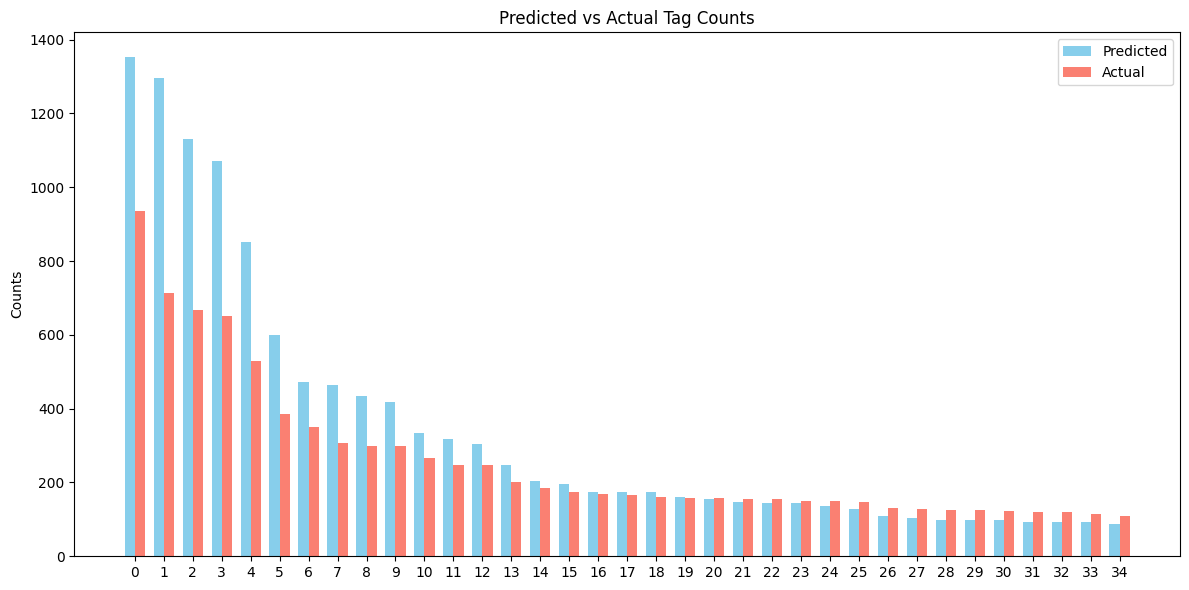

In [171]:

def countHistogram(df_compare:pd.DataFrame, top=35, labels=True):
    top_n = top
    df_top = df_compare.head(top_n)

    x = np.arange(top_n)  # positions for each tag
    width = 0.35          # width of bars

    fig, ax = plt.subplots(figsize=(12,6))

    # Bars
    ax.bar(x - width/2, df_top['pred_count'], width, label='Predicted', color='skyblue')
    ax.bar(x + width/2, df_top['act_count'], width, label='Actual', color='salmon')

    # Labels
    ax.set_ylabel('Counts')
    ax.set_title('Predicted vs Actual Tag Counts')
    ax.set_xticks(x)
    if labels:
        ax.set_xticklabels(df_top['pred_Tag'], rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

countHistogram(df_compare, labels=False)

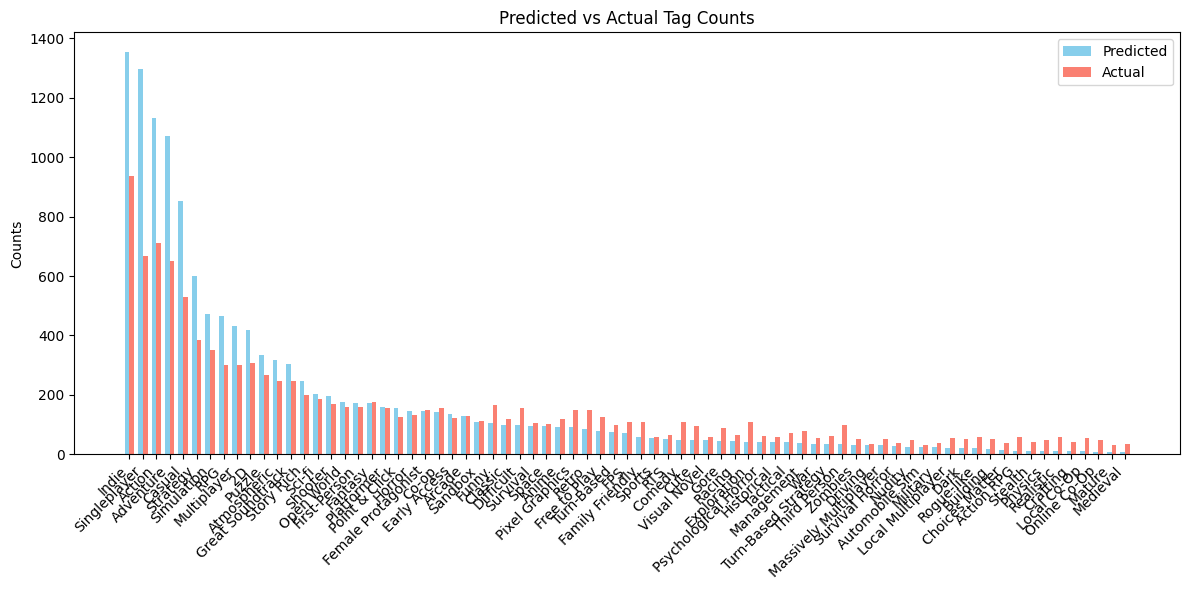

In [172]:
# Make a mapping from predicted tags to their counts
pred_map = dict(zip(top_act[0], top_act[1]))

# Reorder pred tags/counts to follow act_tag ordering
new_act_tags = top_pred[0]
new_act_counts = [pred_map.get(tag, 0) for tag in new_act_tags]  # fallback 0 if missing

# Build dataframe using aligned lists
df_compare = pd.DataFrame({
    'pred_Tag': top_pred[0],
    'pred_count': top_pred[1],
    'act_Tag': new_act_tags,
    'act_count': new_act_counts
})

countHistogram(df_compare, top=75)

In [173]:

def plot_tag_count_distribution_hist(pred_counts, actual_counts, bins=20, title="Tag Count Distribution"):
    """
    Plots the distribution of tag counts using a histogram with bins and a line overlay.
    
    Args:
        pred_counts (array-like): counts of each predicted tag
        actual_counts (array-like): counts of each actual tag
        bins (int or sequence): number of bins or bin edges
        title (str): plot title
    """
    plt.figure(figsize=(12,6))
    
    # Histogram for actual counts
    counts_actual, bin_edges = np.histogram(actual_counts, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(bin_centers, counts_actual, width=(bin_edges[1]-bin_edges[0])*0.4, alpha=0.6,
            label='Actual', color='salmon', edgecolor='black')
    plt.plot(bin_centers, counts_actual, color='red', marker='o', linestyle='-', label='Actual (line)')
    
    # Histogram for predicted counts
    counts_pred, _ = np.histogram(pred_counts, bins=bin_edges)
    plt.bar(bin_centers + (bin_edges[1]-bin_edges[0])*0.4, counts_pred, width=(bin_edges[1]-bin_edges[0])*0.4,
            alpha=0.6, label='Predicted', color='skyblue', edgecolor='black')
    plt.plot(bin_centers, counts_pred, color='blue', marker='o', linestyle='-', label='Predicted (line)')
    
    plt.xlabel("Number of occurrences of a tag")
    plt.ylabel("Number of tags in that bin")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [174]:
def tag_distribution_report(tag_tuple, name="Tag Distribution"):
    """
    Generate a report on the distribution of tag counts.
    tag_tuple: tuple (tags_list, counts_list)
    name: label of the dataset (e.g. 'Predicted' or 'Actual')
    """
    tags, counts = tag_tuple
    counts = np.array(counts)

    report = {
        "Dataset Name": name,
        "Total Unique Tags": len(tags),
        "Total Tag Assignments": counts.sum(),
        "Mean Tag Frequency": counts.mean(),
        "Median Tag Frequency": np.median(counts),
        "Min Tag Frequency": counts.min(),
        "Max Tag Frequency": counts.max(),
        "Std Dev": counts.std(),
        "10th Percentile": np.percentile(counts, 10),
        "25th Percentile": np.percentile(counts, 25),
        "50th Percentile": np.percentile(counts, 50),
        "75th Percentile": np.percentile(counts, 75),
        "90th Percentile": np.percentile(counts, 90),
        "Tags Occurring Once": np.sum(counts == 1),
        "Tags Occurring <= 5": np.sum(counts <= 5),
        "Top 10 Tags Coverage (%)": round(100 * counts[:10].sum() / counts.sum(), 2)
    }

    return pd.DataFrame.from_dict(report, orient='index', columns=[name])


13473 91
12462 98
                          Predicted Tags
Dataset Name              Predicted Tags
Total Unique Tags                     91
Total Tag Assignments              13473
Mean Tag Frequency            148.054945
Median Tag Frequency                44.0
Min Tag Frequency                      1
Max Tag Frequency                   1352
Std Dev                       270.323183
10th Percentile                      3.0
25th Percentile                     12.0
50th Percentile                     44.0
75th Percentile                    144.0
90th Percentile                    417.0
Tags Occurring Once                    3
Tags Occurring <= 5                   13
Top 10 Tags Coverage (%)           60.02 
                           Actual Tags
Dataset Name              Actual Tags
Total Unique Tags                  98
Total Tag Assignments           12462
Mean Tag Frequency         127.163265
Median Tag Frequency             64.5
Min Tag Frequency                  11
Max Tag Frequency

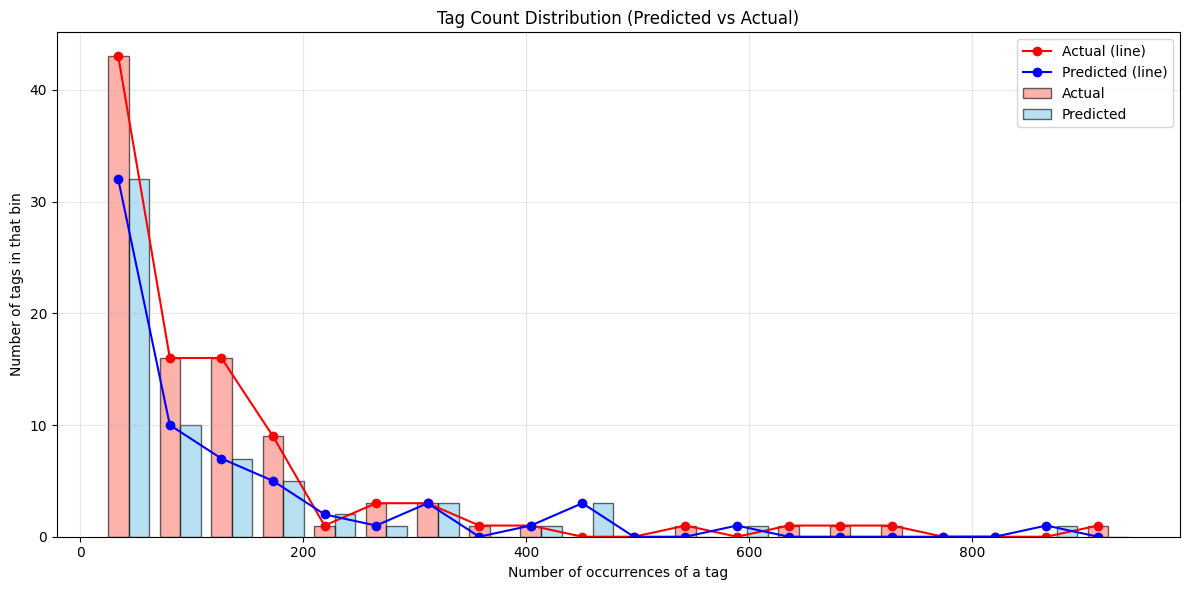

In [175]:
top_pred = find_top_x(top_n_pred_tags, x=len(top_n_pred_tags), print_output=False)
top_act = find_top_x(actual_tags, x=len(actual_tags), print_output=False)

print(tag_distribution_report(top_pred, name="Predicted Tags"), "\n",
tag_distribution_report(top_act, name="Actual Tags"))
plot_tag_count_distribution_hist(top_pred[1], top_act[1], title="Tag Count Distribution (Predicted vs Actual)")

In [176]:
# Convert top-N predicted tag names to a binary matrix
def get_Y_pred(top_n_pred_tags=top_n_pred_tags):
    y_pred = np.zeros_like(y_test)

    for i, tags in enumerate(top_n_pred_tags):
        for tag in tags:
            if tag in mlb.classes_:
                idx = list(mlb.classes_).index(tag)
                y_pred[i, idx] = 1
    return y_pred



In [177]:
from sklearn.metrics import hamming_loss, f1_score, precision_score, recall_score

# y_test: actual multilabel binary matrix
# y_pred: predicted multilabel binary matrix
def ceval(top_n_pred_tags):
    y_pred = get_Y_pred(top_n_pred_tags)
    # Hamming Loss
    hl = hamming_loss(y_test, y_pred)
    print("Hamming Loss:", hl)

    # Micro-averaged precision, recall, F1 (across all games)
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')

    print(f"Micro Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

    # Macro-averaged F1 (average per tag)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"Macro F1 (per tag): {f1_macro:.3f}")

ceval(top_n_pred_tags)

Hamming Loss: 0.0811138014527845
Micro Precision: 0.527, Recall: 0.570, F1: 0.548
Macro F1 (per tag): 0.340


In [178]:
import joblib
import os

def save_trained_model(model, filename, folder="models"):
    """
    Save a trained model to disk.
    
    Args:
        model: trained classifier (e.g., OneVsRestClassifier)
        filename: name of the file (without folder)
        folder: folder to save models (will be created if not exists)
    """
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, filename)
    joblib.dump(model, filepath)
    print(f"Model saved to {filepath}")

def load_trained_model(filename, folder="models"):
    """
    Load a trained model from disk.
    
    Args:
        filename: name of the file
        folder: folder where models are stored
    
    Returns:
        Loaded model
    """
    filepath = os.path.join(folder, filename)
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"No model found at {filepath}")
    model = joblib.load(filepath)
    print(f"Model loaded from {filepath}")
    return model


In [179]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier

def compare_multilabel_models(X_train, y_train, X_test, y_test, mlb, train=False):
    models = {
        "LogisticRegression": OneVsRestClassifier(LogisticRegression(max_iter=1000)) if train else load_trained_model("LogisticRegression_model.joblib"),
        "LinearSVC": OneVsRestClassifier(CalibratedClassifierCV(LinearSVC(max_iter=1000))) if train else load_trained_model("LinearSVC_model.joblib"),
        "SGDClassifier": OneVsRestClassifier(SGDClassifier(loss='log_loss', max_iter=1000)) if train else load_trained_model("SGDClassifier_model.joblib"),
        "LightGBM": OneVsRestClassifier(LGBMClassifier(
            objective='binary',
            boosting_type='gbdt',
            num_leaves=31,
            learning_rate=0.05,
            n_estimators=200
        )) if train else load_trained_model("LightGBM_model.joblib"),
    }
    
    results = []

    for name, clf in models.items():
        print(f"\nTraining {name}...")
        if train:
            clf.fit(X_train, y_train)
        
        print(f"Predicting {name}...")
        # Use dynamic threshold (e.g., 0.3) for probability models
        if hasattr(clf, "predict_proba"):
            probs = clf.predict_proba(X_test)
            threshold = 0.3
            y_pred = list([[mlb.classes_[i] for i, p in enumerate(row) if p >= threshold] 
                               if row.any() else [mlb.classes_[np.argmax(row)]] 
                               for row in probs])
            # Convert back to binary array for metrics
            y_pred_binary = mlb.transform(y_pred)
        else:
            y_pred_binary = clf.predict(X_test)
            # For visualization
            y_pred = mlb.inverse_transform(y_pred_binary)
        
        # Metrics
        hloss = hamming_loss(y_test, y_pred_binary)
        micro_p = precision_score(y_test, y_pred_binary, average='micro', zero_division=0)
        micro_r = recall_score(y_test, y_pred_binary, average='micro', zero_division=0)
        micro_f1 = f1_score(y_test, y_pred_binary, average='micro', zero_division=0)
        macro_f1 = f1_score(y_test, y_pred_binary, average='macro', zero_division=0)
        
        results.append({
            "Model": name,
            "Hamming Loss": hloss,
            "Micro Precision": micro_p,
            "Micro Recall": micro_r,
            "Micro F1": micro_f1,
            "Macro F1": macro_f1
        })
        
        # Visualize predicted vs actual tag counts
        pred_counts = np.array([len(tags) for tags in y_pred])
        act_counts = np.array([len(tags) for tags in mlb.inverse_transform(y_test)])
        
        plt.figure(figsize=(8,5))
        plt.hist(pred_counts, bins=20, alpha=0.5, label='Predicted')
        plt.hist(act_counts, bins=20, alpha=0.5, label='Actual')
        plt.xlabel("Number of tags per game")
        plt.ylabel("Number of games")
        plt.title(f"Tag Count Distribution - {name}")
        plt.legend()
        plt.show()
    
    return pd.DataFrame(results), models

# Example usage:
# results_df = compare_multilabel_models(X_train, y_train, X_test, y_test, mlb)
# print(results_df)
train = False
results_df, trained_models = compare_multilabel_models(X_train, y_train, X_test, y_test, mlb, train=train)
if train:
    for i, model_name in enumerate(trained_models.keys()):
        save_trained_model(trained_models[model_name], f"{model_name}_model.joblib")

Model loaded from models\LogisticRegression_model.joblib
Model loaded from models\LinearSVC_model.joblib
Model loaded from models\SGDClassifier_model.joblib
Model loaded from models\LightGBM_model.joblib

Training LogisticRegression...
Predicting LogisticRegression...


ValueError: X has 768 features, but LogisticRegression is expecting 384 features as input.

In [ ]:
print(results_df)

                Model  Hamming Loss  Micro Precision  Micro Recall  Micro F1  \
0  LogisticRegression      0.025040         0.554224      0.356561  0.433943   
1           LinearSVC      0.024998         0.552780      0.373483  0.445778   
2       SGDClassifier      0.025304         0.545430      0.359794  0.433578   
3            LightGBM      0.024943         0.568216      0.305528  0.397384   

   Macro F1  
0  0.085331  
1  0.164042  
2  0.093242  
3  0.070338  
